In [1]:
import pandas as pd

In [87]:
# data import

import boto3
from io import BytesIO
import zipfile
from dotenv import load_dotenv
load_dotenv()
import os


aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")
verbose=True
bucket_name="disease-risk-app"
zip_key="disease-risk-app_zip.zip"

s3 = boto3.client(
's3',
aws_access_key_id=aws_access_key_id,
aws_secret_access_key=aws_secret_access_key
)
response = s3.get_object(Bucket=bucket_name, Key=zip_key)
zip_bytes = BytesIO(response['Body'].read())
with zipfile.ZipFile(zip_bytes) as z:
    if verbose:
        print("Files in ZIP:", z.namelist())
    with z.open(z.namelist()[0]) as f:
        df = pd.read_csv(f)
# df.shape
df.head(10)

Files in ZIP: ['disease-risk-app.csv']


,id,age,gender,bmi,daily_steps,sleep_hours,water_intake_l,calories_consumed,smoker,alcohol,resting_hr,systolic_bp,diastolic_bp,cholesterol,family_history,disease_risk
0,1,56,Male,20.5,4198,3.9,3.4,1602,0,0,97,161,111,240,0,0
1,2,69,Female,33.3,14359,9.0,4.7,2346,0,1,68,116,65,207,0,0
2,3,46,Male,31.6,1817,6.6,4.2,1643,0,1,90,123,99,296,0,0
3,4,32,Female,38.2,15772,3.6,2.0,2460,0,0,71,165,95,175,0,0
4,5,60,Female,33.6,6037,3.8,4.0,3756,0,1,98,139,61,294,0,0
5,6,25,Male,27.3,19495,5.0,4.4,1301,0,1,73,107,65,284,0,0
6,7,78,Female,37.1,16739,9.5,4.2,3478,1,0,90,110,102,201,0,0
7,8,38,Female,18.9,1726,4.8,1.7,3212,0,1,64,113,109,197,0,0
8,9,56,Female,18.2,1764,5.1,1.5,3740,0,1,91,112,61,237,1,0
9,10,75,Male,23.5,9730,4.5,0.7,3571,0,1,54,177,90,157,1,0


In [3]:
# value counts

cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    print(f"\n Value counts for column: '{col}'")
    print(df[col].value_counts())


 Value counts for column: 'gender'
gender
Male      50132
Female    49868
Name: count, dtype: int64


In [4]:
# drop use less columns
df= df.drop(columns="id")

# percentage of blank columns

total_rows = len(df)
blank_counts = df.isna().sum() + (df.astype(str).apply(lambda x: x.str.strip()) == '').sum()
blank_percentage = (blank_counts / total_rows) * 100
# print(blank_percentage)

In [5]:
df_filled = df.copy()


# Fill numeric columns with mean
num_cols = df_filled.select_dtypes(include='number').columns
for col in num_cols:
    df_filled[col] = df_filled[col].fillna(df_filled[col].mean())

# Fill categorical columns with mode
cat_cols = df_filled.select_dtypes(include='object').columns
for col in cat_cols:
    df_filled[col] = df_filled[col].fillna(df_filled[col].mode()[0])
# df_filled.head(10)

In [6]:
# removing outliers

from scipy.stats import zscore

# Select numeric columns
numeric_cols = df.select_dtypes(exclude='object').columns

# Compute Z-scores
z_scores = df[numeric_cols].apply(zscore)

# Create mask for rows where all Z-scores are within threshold
threshold = 3
mask = (z_scores.abs() < threshold).all(axis=1)
df_filtered = df[mask]
# print(df_filtered.shape)

In [7]:
# data encoding 
from sklearn.preprocessing import LabelEncoder


df_encoded = df_filtered.copy()
ordinal_map= None
cardinality_threshold=5

for col in df.select_dtypes(include='object').columns:
    unique_vals = df[col].nunique()

    # Ordinal encoding if ordinality exists
    if ordinal_map and col in ordinal_map:
        ordered_categories = ordinal_map[col]
        df_encoded[col] = df[col].astype(
            pd.CategoricalDtype(categories=ordered_categories, ordered=True)
        ).cat.codes

    # One-hot encoding for low-cardinality nominal features
    elif unique_vals <= cardinality_threshold:
        df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=True)

    # Label encoding for high-cardinality nominal features
    else:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
# df_encoded
# bool_cols

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

target_column="disease_risk"
y=df_encoded[target_column]
x= df_encoded.drop(columns=target_column)
x_scaled= pd.DataFrame(scaler.fit_transform(x),columns=x.columns, index=x.index)
# x_scaled
# y
print(y.value_counts())


disease_risk
0    75179
1    24821
Name: count, dtype: int64


In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
x_scaled, y,stratify=y ,test_size=0.25, random_state=42)

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

classifiers = {
    'LogisticRegression': LogisticRegression(),
    # 'DecisionTree': DecisionTreeClassifier(),
    # 'RandomForest': RandomForestClassifier(),
    # 'GradientBoosting': GradientBoostingClassifier(),
    # 'XGBoost': XGBClassifier(verbosity=0),
    # 'CatBoost': CatBoostClassifier(verbose=0),
    # 'LightGBM': LGBMClassifier(),
    # 'KNN': KNeighborsClassifier(),
    # 'NaiveBayes': GaussianNB(),
    # 'LDA': LinearDiscriminantAnalysis()
}

In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

import mlflow
import dagshub

mlflow.set_tracking_uri('https://dagshub.com/arpitmishra917/disease-risk-app.mlflow')
dagshub.init(repo_owner='arpitmishra917', repo_name='disease-risk-app', mlflow=True)


random_state=42
resamplers = {
    'SMOTE': SMOTE(random_state=random_state),
    # 'RandomUnderSampler': RandomUnderSampler(random_state=random_state),
    # 'SMOTE_Tomek': SMOTETomek(random_state=random_state)
}

all_results = {}
for resample_name, resampler in resamplers.items():
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)
    print(f"\n🔁 Resampling: {resample_name} — Resampled shape: {X_resampled.shape}")


    for name, model in classifiers.items():
        with mlflow.start_run(run_name=f"{resample_name}_{name}"):
            model.fit(X_resampled, y_resampled)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

            result= {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None
            # 'Confusion Matrix': confusion_matrix(y_test, y_pred)
        }
            
            all_results[(resample_name, name)] = result

            for metric_name, metric_value in result.items():
                mlflow.log_metric(metric_name, metric_value)


all_results


Initialized MLflow to track repo "arpitmishra917/disease-risk-app"

Repository arpitmishra917/disease-risk-app initialized!


🔁 Resampling: SMOTE — Resampled shape: (112768, 14)
🏃 View run SMOTE_LogisticRegression at: https://dagshub.com/arpitmishra917/disease-risk-app.mlflow/#/experiments/0/runs/0b6fe356e42e47c098f28d6a59dc1fe1
🧪 View experiment at: https://dagshub.com/arpitmishra917/disease-risk-app.mlflow/#/experiments/0


{('SMOTE', 'LogisticRegression'): {'Accuracy': 0.50208,
  'Precision': 0.2503798480607757,
  'Recall': 0.5045930701047542,
  'F1 Score': 0.33468733297701764,
  'ROC AUC': 0.5021821557887715}}

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

thresh = 0.495
y_pred_thresh = (y_proba >= thresh).astype(int)

acc = accuracy_score(y_test, y_pred_thresh)
prec = precision_score(y_test, y_pred_thresh)
rec = recall_score(y_test, y_pred_thresh)
f1 = f1_score(y_test, y_pred_thresh)

print(f"Threshold: {thresh}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Threshold: 0.495
Accuracy: 0.3936
Precision: 0.2475
Recall: 0.7077
F1 Score: 0.3668


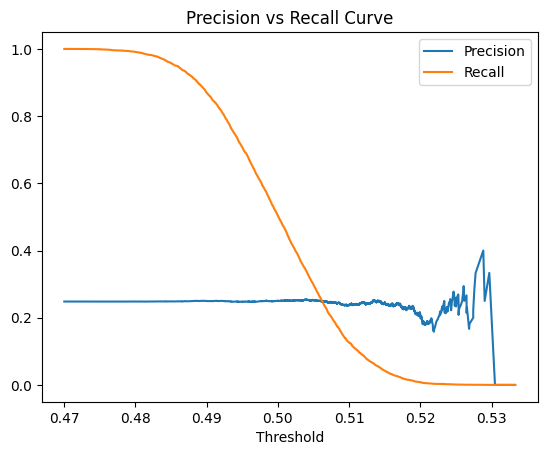

In [86]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision vs Recall Curve')
plt.show()